In [1]:
!pip install kagglehub

In [9]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf

from sklearn.cluster import MiniBatchKMeans
import glob
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
)

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [ ]:

import os
import shutil
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

# Step 1 - Download the dataset
path = kagglehub.dataset_download("madhushreesannigrahi/fish-recognition-ground-truth-data")
print("Dataset base path:", path)

# Step 2 - Folder that contains fish_**
fish_image_path = os.path.join(path, "fish_image")

# Step 3 - Classes you want
selected_classes = ["fish_01", "fish_02", "fish_03", "fish_04", "fish_05", "fish_07"]

# Step 4 - Destination folder
new_dataset_path = "/content/fish_selected_6_classes.5"
os.makedirs(new_dataset_path, exist_ok=True)

# Create augmentation generator
aug_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

TARGET_COUNT = 1000

# Step 5 - Process each class
for class_name in selected_classes:
    src = os.path.join(fish_image_path, class_name)
    dst = os.path.join(new_dataset_path, class_name)

    if not os.path.exists(src):
        print(f"Class not found: {class_name}")
        continue

    os.makedirs(dst, exist_ok=True)

    # Get all images in the source folder
    images = sorted(glob.glob(src + "/*"))

    # Copy first 2500 images (or all if less)
    copied_count = 0
    for img_path in images[:2500]:
        shutil.copy(img_path, dst)
        copied_count += 1

    print(f"Copied {copied_count} images from {class_name}")

    # If less than 1000 images → use augmentation
    if copied_count < TARGET_COUNT:
        needed = TARGET_COUNT - copied_count
        print(f"{class_name} needs augmentation: {needed} images")

        img_files = glob.glob(dst + "/*")  # existing (copied) images

        aug_count = 0
        idx = 0

        while aug_count < needed:
            img = load_img(img_files[idx])
            img_array = img_to_array(img)
            img_array = img_array.reshape((1,) + img_array.shape)

            # Generate 1 augmentation image at a time
            for batch in aug_gen.flow(img_array, batch_size=1,
                                      save_to_dir=dst,
                                      save_prefix="aug",
                                      save_format="jpg"):
                aug_count += 1
                break

            idx = (idx + 1) % len(img_files)

        print(f"Finished augmentation for {class_name}: now 1000 images total")

print("===== Dataset Processing Complete =====")

100%|██████████| 457M/457M [00:03<00:00, 143MB/s]

Extracting files...


Dataset base path: /root/.cache/kagglehub/datasets/madhushreesannigrahi/fish-recognition-ground-truth-data/versions/1
Copied 2500 images from fish_01
Copied 2500 images from fish_02
Copied 2500 images from fish_03
Copied 2500 images from fish_04
Copied 2500 images from fish_05
Copied 450 images from fish_07
fish_07 needs augmentation: 550 images
Finished augmentation for fish_07: now 1000 images total
===== Dataset Processing Complete =====


In [3]:
from google.colab import drive
drive.mount('/content/drive')

save_dir = "/content/drive/MyDrive/fish_results"      # where results will be saved
import os
os.makedirs(save_dir, exist_ok=True)

Mounted at /content/drive


In [4]:
import glob
import numpy as np
import os

img_paths = []
labels = []

# Make sure paths are correct
classes = sorted(os.listdir(new_dataset_path))

# All image extensions you want to include
extensions = ["*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG"]

for class_name in classes:
    class_folder = os.path.join(new_dataset_path, class_name)

    for ext in extensions:
        for img_file in glob.glob(os.path.join(class_folder, ext)):
            img_paths.append(img_file)
            labels.append(class_name)

img_paths = np.array(img_paths)
labels = np.array(labels)

print("Total images:", len(img_paths))
print("Classes:", classes)



Total images: 13481
Classes: ['fish_01', 'fish_02', 'fish_03', 'fish_04', 'fish_05', 'fish_07']


In [5]:
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()
labels_encoded = label_enc.fit_transform(labels)

num_classes = len(label_enc.classes_)
print("Number of classes:", num_classes)

Number of classes: 6


In [10]:
# Convert dataset to DataFrame
def convert_to_df(ds):
    image_paths, labels = [], []
    # loop through the 23 subfolders (fish1, fish2, ..., fish23)
    for folder in sorted(os.listdir(ds)):
        folder_path = os.path.join(ds, folder)
        if os.path.isdir(folder_path):
            label_name = folder  # e.g. "fish1"
            for file in os.listdir(folder_path):
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(folder_path, file))
                    labels.append(label_name)
    return pd.DataFrame({'image_path': image_paths, 'label': labels})


# convert fish folders into dataframes
fish_df = convert_to_df(new_dataset_path)


# check results
print(f"✅ Loaded {len(fish_df)} total images")
print("Number of classes:", fish_df['label'].nunique())
print("Classes:", fish_df['label'].unique())

✅ Loaded 13481 total images
Number of classes: 6
Classes: ['fish_01' 'fish_02' 'fish_03' 'fish_04' 'fish_05' 'fish_07']


HOG feature extraction

In [12]:
from skimage.feature import hog

X = []
y = []
class_names = sorted(os.listdir(new_dataset_path))

for label, cls in enumerate(class_names):
    class_folder = os.path.join(new_dataset_path, cls)

    for img_file in os.listdir(class_folder):
        if img_file.lower().endswith((".jpg",".jpeg",".png")):
            img_path = os.path.join(class_folder, img_file)

            # Read and preprocess
            img = cv2.imread(img_path)
            img = cv2.resize(img, (128, 128))
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # HOG feature extraction
            hog_features = hog(gray,
                               orientations=9,
                               pixels_per_cell=(8, 8),
                               cells_per_block=(2, 2),
                               block_norm="L2-Hys")

            X.append(hog_features)
            y.append(label)

X = np.array(X)
y = np.array(y)
print("HOG feature shape:", X.shape)

HOG feature shape: (13481, 8100)


HOG visualization

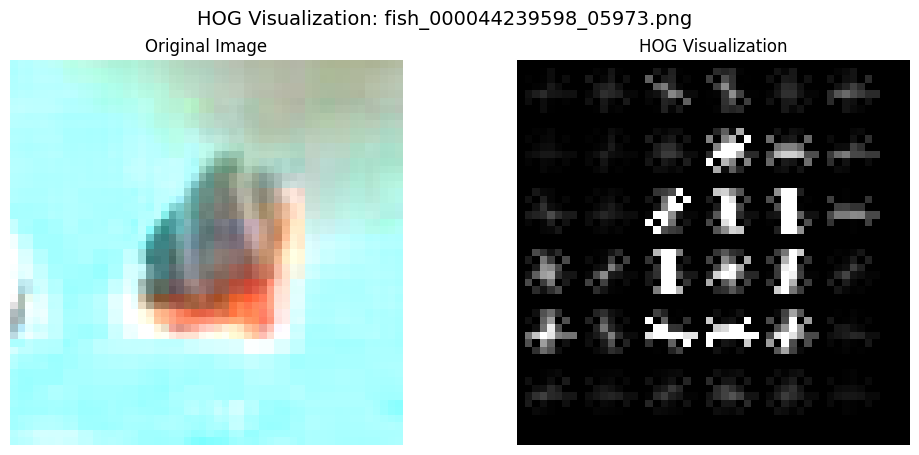

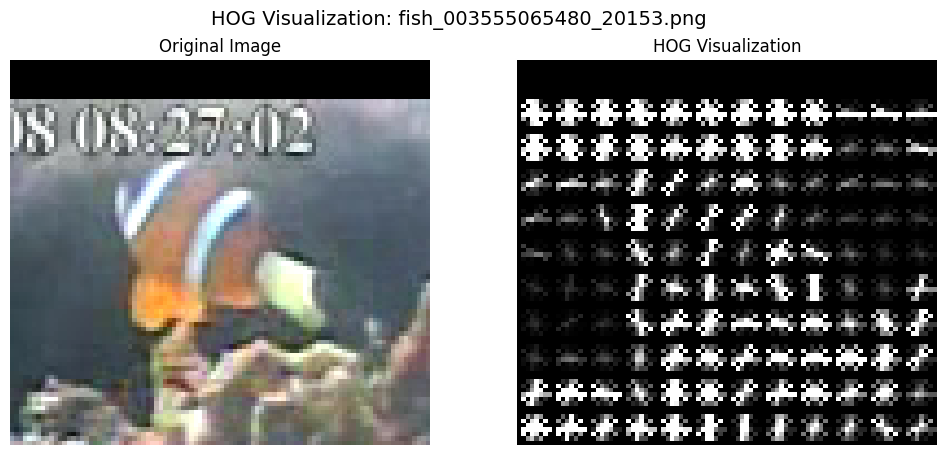

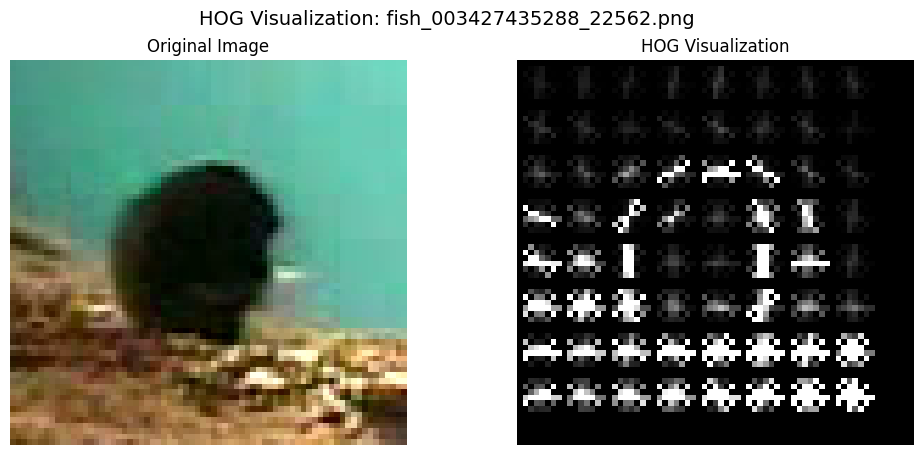

In [16]:
import random
from skimage import exposure

# Collect all image paths from every class folder
all_images = []
for class_name in os.listdir(new_dataset_path):
    class_folder = os.path.join(new_dataset_path, class_name)
    if os.path.isdir(class_folder):
        for img_file in os.listdir(class_folder):
            if img_file.lower().endswith((".jpg", ".png", ".jpeg")):
                all_images.append(os.path.join(class_folder, img_file))

# Pick 3 random images
selected_images = random.sample(all_images, 3)

# Process and visualize each image
for i, img_path in enumerate(selected_images):
    # Read image
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute HOG
    hog_features, hog_image = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=True,
        block_norm='L2-Hys'
    )

    # Enhance visualization
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # Display
    plt.figure(figsize=(12, 5))
    plt.suptitle(f"HOG Visualization: {os.path.basename(img_path)}", fontsize=14)

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("HOG Visualization")
    plt.imshow(hog_image_rescaled, cmap="gray")
    plt.axis('off')

    plt.show()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:

# 5-FOLD CROSS VALIDATION and Store predictions per fold

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

metrics = {
    "SVM": {"acc": [], "preds": [], "truth": []},
    "KNN": {"acc": [], "preds": [], "truth": []},
    "ANN": {"acc": [], "preds": [], "truth": []}
}

fold = 1

for train_idx, test_idx in skf.split(X, y):
    print(f"\n==================== FOLD {fold} ====================")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    models = {
        "SVM": SVC(kernel="rbf"),
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "ANN": MLPClassifier(hidden_layer_sizes=(256,128),
                             activation="relu",
                             solver="adam",
                             max_iter=40,
                             random_state=42)
    }

    for model_name, model in models.items():
        print(f"\n---- {model_name} ----")

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        metrics[model_name]["acc"].append(acc)
        metrics[model_name]["preds"].append(y_pred)
        metrics[model_name]["truth"].append(y_test)

        print("Fold Accuracy:", acc)

    fold += 1



==================== FOLD 1 ====================

---- SVM ----
Fold Accuracy: 0.9562476826103078

---- KNN ----
Fold Accuracy: 0.8987764182424917

---- ANN ----
Fold Accuracy: 0.9610678531701891

==================== FOLD 2 ====================

---- SVM ----
Fold Accuracy: 0.9566023738872403

---- KNN ----
Fold Accuracy: 0.8998516320474778

---- ANN ----
Fold Accuracy: 0.9636498516320475

==================== FOLD 3 ====================

---- SVM ----
Fold Accuracy: 0.9591988130563798

---- KNN ----
Fold Accuracy: 0.9061572700296736

---- ANN ----
Fold Accuracy: 0.9614243323442137

==================== FOLD 4 ====================

---- SVM ----
Fold Accuracy: 0.9573442136498517

---- KNN ----
Fold Accuracy: 0.8942878338278932

---- ANN ----
Fold Accuracy: 0.9658753709198813

==================== FOLD 5 ====================

---- SVM ----
Fold Accuracy: 0.962166172106825

---- KNN ----
Fold Accuracy: 0.901706231454006

---- ANN ----
Fold Accuracy: 0.9695845697329377



 BEST FOLD RESULTS FOR ANN 
Best Fold Index: 5
Best Accuracy: 0.9695845697329377

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       500
           1       0.96      0.95      0.95       500
           2       0.95      0.97      0.96       500
           3       0.97      0.98      0.98       500
           4       0.99      0.99      0.99       500
           5       0.98      0.97      0.97       196

    accuracy                           0.97      2696
   macro avg       0.97      0.97      0.97      2696
weighted avg       0.97      0.97      0.97      2696



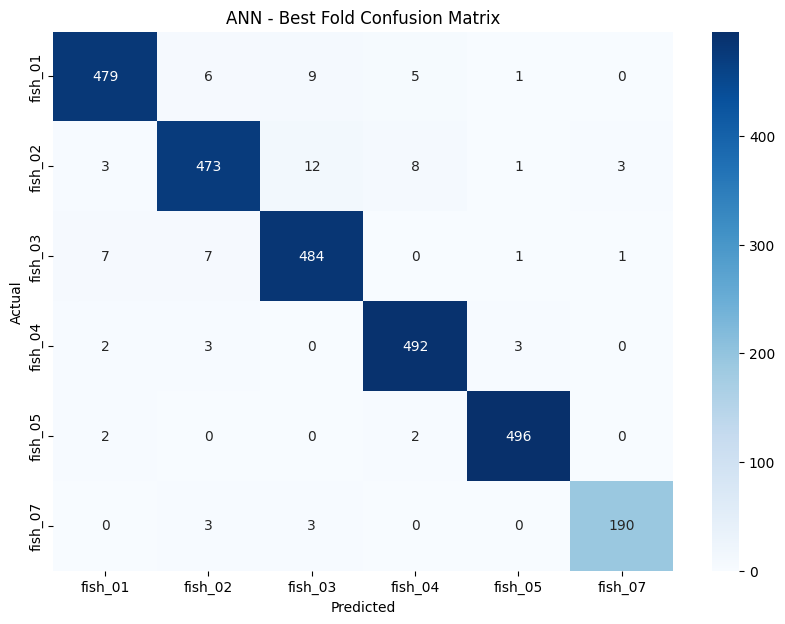


 BEST FOLD RESULTS FOR KNN 
Best Fold Index: 3
Best Accuracy: 0.9061572700296736

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       500
           1       0.87      0.85      0.86       500
           2       0.87      0.91      0.89       500
           3       0.96      0.89      0.92       500
           4       0.90      0.99      0.94       500
           5       0.99      0.83      0.90       196

    accuracy                           0.91      2696
   macro avg       0.92      0.90      0.91      2696
weighted avg       0.91      0.91      0.91      2696



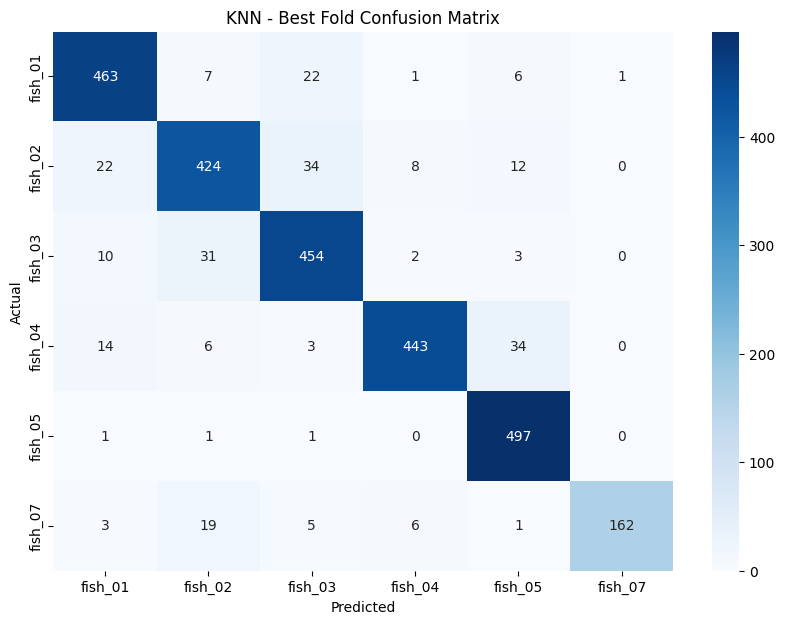


 BEST FOLD RESULTS FOR SVM 
Best Fold Index: 5
Best Accuracy: 0.962166172106825

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       500
           1       0.95      0.94      0.94       500
           2       0.96      0.96      0.96       500
           3       0.97      0.99      0.98       500
           4       0.98      0.98      0.98       500
           5       0.98      0.94      0.96       196

    accuracy                           0.96      2696
   macro avg       0.96      0.96      0.96      2696
weighted avg       0.96      0.96      0.96      2696



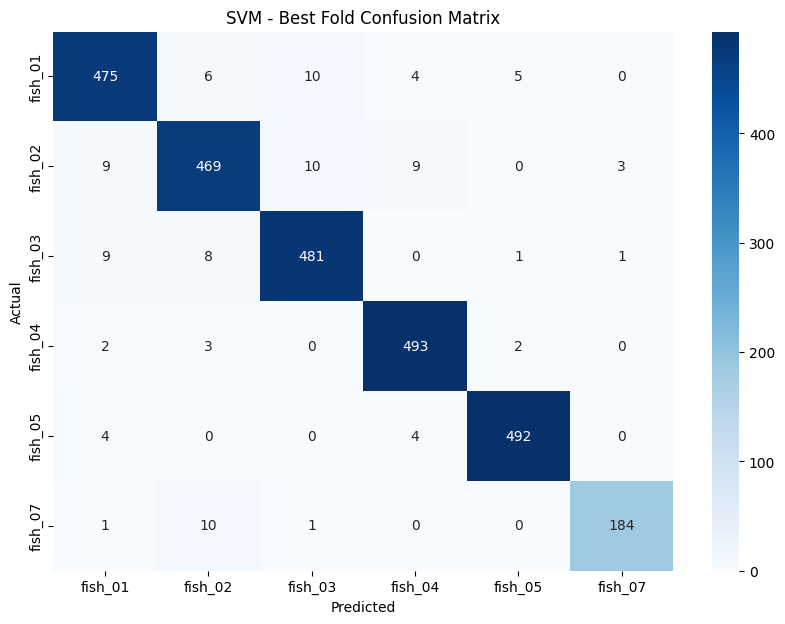

In [20]:
# BEST FOLD REPORT AND CONFUSION MATRIX FOR EACH MODEL

def show_results_for_best_fold(model_name):
    print("\n============================================")
    print(f" BEST FOLD RESULTS FOR {model_name} ")
    print("============================================")

    # Find index of best fold
    best_fold = np.argmax(metrics[model_name]["acc"])
    best_acc = metrics[model_name]["acc"][best_fold]

    print(f"Best Fold Index: {best_fold + 1}")
    print(f"Best Accuracy: {best_acc}")

    y_true = metrics[model_name]["truth"][best_fold]
    y_pred = metrics[model_name]["preds"][best_fold]

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",xticklabels=classes,
        yticklabels=classes)
    plt.title(f"{model_name} - Best Fold Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


# Show best fold results
show_results_for_best_fold("ANN")
show_results_for_best_fold("KNN")
show_results_for_best_fold("SVM")